# Zero-copy communication between C++ and Python

Numpy arrays are just C arrays wrapped with metadata in Python. Thus, we can share data between C and Python without even copying. In general, this communication is

   * not overwrite safe: Python protects against out-of-range indexes, but C/C++ does not;
   * not type safe: no guarantee that C and Python will interpret bytes in memory the same way, including endianness;
   * not thread safe: no protection at all against concurrent access.

But without much overhead, we can wrap a shared array (or collection of arrays) in two APIs— one in C++, one in Python— to provide these protections.

`commonblock` is a nascent library to do this. It passes array lengths and types from Python to C++ via `ctypes` and uses `librt.so` (wrapped by `prwlock` in Python) to implement locks that are usable on both sides.

In [1]:
import numpy
import commonblock

tracks = commonblock.NumpyCommonBlock(
    trackermu_qoverp     = numpy.zeros(1000, dtype=numpy.double),
    trackermu_qoverp_err = numpy.zeros(1000, dtype=numpy.double),
    trackermu_phi        = numpy.zeros(1000, dtype=numpy.double),
    trackermu_eta        = numpy.zeros(1000, dtype=numpy.double),
    trackermu_dxy        = numpy.zeros(1000, dtype=numpy.double),
    trackermu_dz         = numpy.zeros(1000, dtype=numpy.double),
    globalmu_qoverp      = numpy.zeros(1000, dtype=numpy.double),
    globalmu_qoverp_err  = numpy.zeros(1000, dtype=numpy.double))

hits = commonblock.NumpyCommonBlock(
    detid      = numpy.zeros(5000, dtype=numpy.uint64),
    localx     = numpy.zeros(5000, dtype=numpy.double),
    localy     = numpy.zeros(5000, dtype=numpy.double),
    localx_err = numpy.zeros(5000, dtype=numpy.double),
    localy_err = numpy.zeros(5000, dtype=numpy.double))

# Using it in CMSSW

CMSSW can be executed within a Python process, thanks to Chris's [PR #17236](https://github.com/cms-sw/cmssw/pull/17236). Since the configuration language is also in Python, you can build the configuration and start CMSSW in the same Python process.

We can get our common block into CMSSW by passing its pointer as part of a `ParameterSet`. Since this is all one process, that pointer address is still valid when CMSSW launches.

In [2]:
import FWCore.ParameterSet.Config as cms

process = cms.Process("Demo")

process.load("FWCore.MessageService.MessageLogger_cfi")

process.maxEvents = cms.untracked.PSet(input = cms.untracked.int32(1000))

process.source = cms.Source(
    "PoolSource", fileNames = cms.untracked.vstring("file:MuAlZMuMu-2016H-002590494DA0.root"))

process.demo = cms.EDAnalyzer(
    "DemoAnalyzer",
    tracks = cms.uint64(tracks.pointer()),   # pass the arrays to C++ as a pointer
    hits   = cms.uint64(hits.pointer()))

process.p = cms.Path(process.demo)

# On the C++ side

`NumpyCommonBlock.h` is a header-only library that defines the interface. We pick up the object by casting the pointer:

```
   tracksBlock = (NumpyCommonBlock*)iConfig.getParameter<unsigned long long>("tracks");
   hitsBlock   = (NumpyCommonBlock*)iConfig.getParameter<unsigned long long>("hits");
```

and then get safe accessors to each array with a templated method that checks C++'s compiled type against Python's runtime type.

```
   trackermu_qoverp     = tracksBlock->newAccessor<double>("trackermu_qoverp");
   trackermu_qoverp_err = tracksBlock->newAccessor<double>("trackermu_qoverp_err");
   trackermu_phi        = tracksBlock->newAccessor<double>("trackermu_phi");
   trackermu_eta        = tracksBlock->newAccessor<double>("trackermu_eta");
   trackermu_dxy        = tracksBlock->newAccessor<double>("trackermu_dxy");
   trackermu_dz         = tracksBlock->newAccessor<double>("trackermu_dz");
   globalmu_qoverp      = tracksBlock->newAccessor<double>("globalmu_qoverp");
   globalmu_qoverp_err  = tracksBlock->newAccessor<double>("globalmu_qoverp_err");

   detid      = hitsBlock->newAccessor<uint64_t>("detid");
   localx     = hitsBlock->newAccessor<double>("localx");
   localy     = hitsBlock->newAccessor<double>("localy");
   localx_err = hitsBlock->newAccessor<double>("localx_err");
   localy_err = hitsBlock->newAccessor<double>("localy_err");
```

# Running CMSSW

Chris's `PythonEventProcessor.run()` method blocks, so I put it in a thread to let CMSSW and Python run at the same time.

I had to release the GIL with [PR #18683](https://github.com/cms-sw/cmssw/pull/18683) to make this work, and that feature will work its way into releases eventually.

In [3]:
import threading
import libFWCorePythonFramework
import libFWCorePythonParameterSet

class CMSSWThread(threading.Thread):
    def __init__(self, process):
        super(CMSSWThread, self).__init__()
        self.process = process

    def run(self):
        processDesc = libFWCorePythonParameterSet.ProcessDesc()
        self.process.fillProcessDesc(processDesc.pset())

        cppProcessor = libFWCorePythonFramework.PythonEventProcessor(processDesc)
        cppProcessor.run()

# Demonstration

In this demo, I loop over AlCaZMuMu muons and fill the arrays with track parameters (before and after adding muon hits to the fit) and display them as Pandas DataFrames as soon as they're full (before CMSSW finishes).

The idea is that one would stream data from CMSSW into some Python thing in large blocks (1000 tracks/5000 hits at a time in this example).

Bi-directional communication is possible, but I don't know what it could be used for.

In [4]:
cmsswThread = CMSSWThread(process)
cmsswThread.start()

tracks.wait(1)   # CMSSW notifies that it has filled the tracks array
tracks.pandas()

,globalmu_qoverp,globalmu_qoverp_err,trackermu_dxy,trackermu_dz,trackermu_eta,trackermu_phi,trackermu_qoverp,trackermu_qoverp_err
0,-0.010567,0.000176,-0.068008,5.044248,1.345596,-2.698669,-0.010630,0.000154
1,0.006895,0.000151,0.054830,4.506279,1.833096,0.569517,0.006876,0.000148
2,0.019243,0.000203,0.049390,-1.901605,0.103585,0.658894,0.019275,0.000230
3,-0.023387,0.000218,-0.095338,-1.904487,-0.249766,-2.945127,-0.023375,0.000224
4,-0.004139,0.000135,0.116625,-8.595935,-1.881879,-0.706054,-0.004042,0.000107
5,0.015591,0.000239,-0.066035,-8.682809,-1.252449,-2.672938,0.015586,0.000239
6,0.037974,0.000364,0.032850,-0.111745,-0.257494,-1.806014,0.037933,0.000375
7,-0.009422,0.000226,0.009904,-0.572965,2.108640,0.986081,-0.009398,0.000228
8,0.018069,0.000190,0.119466,-1.273930,0.374561,-0.530472,0.018046,0.000195
9,-0.022957,0.000241,-0.111564,-1.262620,0.426754,2.919330,-0.022932,0.000246


In [5]:
hits.pandas()

,detid,localx,localx_err,localy,localy_err
0,604018352,-14.661780,0.000339,8.819818,0.141031
1,637612422,15.698437,1.642616,0.000000,200.085754
2,637579686,16.581907,2.337946,0.000000,317.243591
3,604021936,-15.579300,0.000682,-75.140610,0.308281
4,604026032,17.155981,0.000775,-1.725272,0.355754
5,637645258,-17.506124,2.727962,0.000000,304.015594
6,604030128,18.839199,0.000826,47.635704,0.334478
7,637612522,19.774876,3.734178,0.000000,480.071472
8,604017696,4.622838,0.000176,9.101110,0.141533
9,604021264,27.893734,0.000855,21.453674,0.048724


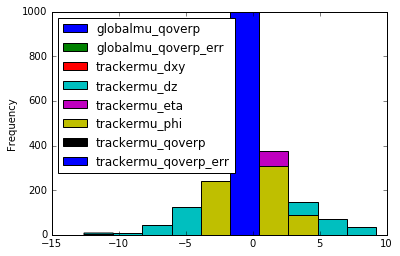

In [7]:
%matplotlib inline

tracks.pandas().plot.hist()

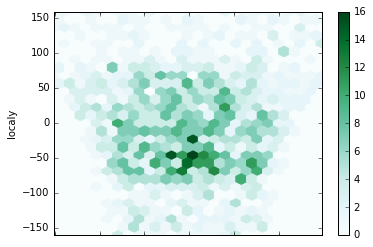

In [21]:
df = hits.pandas()

df[numpy.abs(df.localy) > 0].plot.hexbin(x="localx", y="localy", gridsize=25)

# Higher-level interfaces

This example uses a `notify`/`wait` mechanism like basic Java. (The EDAnalyzer says `notify(1)` when the arrays are full and the Python code above blocks with `wait(1)`.)

This is lock-level programming and is easy to get wrong. Some common use-patterns, like streaming data out of CMSSW in the above example, would be better served by canned classes that look like a Python generator that yields a block of data while CMSSW fills the next. Also, I need to modernize my C++.

# Possible uses

   * Running machine learning algorithms from Scikit-Learn et al in an EDAnalyzer (for a user's analysis) or an EDProducer (jet substructure, track identification, etc., though I'd be wary of using such an exotic method in production).
   
   
   * Applying last-minute jet energy corrections in [Oli & Matteo's analysis](https://cms-big-data.github.io/) on Spark without rewriting those algorithms for the JVM. CMSSW would have to be installed on the Spark cluster (analytix.cern.ch).
   
   
   * Alignment and calibrations! When I was last involved in AlCa, each group effectively invented their own map-reduce framework because alignment and calibration jobs have this form. In alignment, the mapping phase consists of refitting tracks with a new geometry, which must be done in CMSSW, and the reducing phase consists of collecting residuals by DetId, fitting, and updating the global geometry. If a TTreeCache can keep the input tracks and hits in memory on a cluster of CMSSW worker nodes, AlCa algorithms could see the factor-of-100 speed up from avoiding disk in fitting iterations.